In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from random import uniform
import time
import random

In [2]:
os.chdir('/Users/elizabeth/Desktop/BMI203_HW3/data')

In [3]:
def read_pairs(file):
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Create a list of the paired filenames
    files = [line.split()for line in lines]
    return files

def read_sequence(file):
    #Store protein name
    protein_name = file.split('/')[-1][:-3]
    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Remove the header
    lines = lines[1:]
    #Initialize array to store sequence
    sequence = ''
    for line in lines:
        sequence = sequence + line
    sequence = sequence.upper()
    return protein_name, sequence

def read_scoring_matrix(file):

    #Open the file
    f = open ( file , 'r')
    #Read all the lines
    lines = f.read().splitlines()
    #Find where the header ends
    aa_names_index = 0
    while lines[aa_names_index][0] == '#':
        aa_names_index = aa_names_index +1
    #Remove header
    lines = lines[aa_names_index:]
    #Initialize DataFrame to store scoring matrix
    amino_acids = lines[0].split()
    scoring_df = pd.DataFrame(index=amino_acids, columns=amino_acids)
    #Store scores into dataframe
    for line_index in range(1,len(lines)):
        scoring_df.iloc[line_index-1] = lines[line_index].split()
    #Convert scores to numbers from strings
    scoring_df = scoring_df.apply(pd.to_numeric)   
    return scoring_df

def smith_waterman_alignment(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))
    
    A_direction = {}
    B_direction = {}
    M_direction = {}
    for i in range(dim_a):
        A_direction[i,0] = "end"
        B_direction[i,0] = "end"
        M_direction[i,0] = "end"
    for j in range(dim_b):
        A_direction[0,j] = "end"
        B_direction[0,j] = "end"
        M_direction[0,j] = "end"

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN


    #Make list to keep track of direction
    event_gap_a = ["open_gap_a", "extend_gap_a", "open_gap_a_from_b"]
    event_gap_b = ["open_gap_b", "extend_gap_b", "open_gap_b_from_a"]
    event_match = ["match", "close_gap_a","close_gap_b","end"]
    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)
            A_direction[i,j] = event_gap_a[values.index(A[i,j])]
            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)
            B_direction[i,j] = event_gap_b[values.index(B[i,j])]
            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
            M_direction[i,j] = event_match[values.index(max(values))]
    if M.max() == 0:
        return "","",0

    #Do traceback to get aligned sequence
    #Initalize strings to contan alignment

    #Find index of max score position in Z
    indices = np.where(M == M.max())
    
    #If there are multiple alignments take the first position
    index_a = indices[0][0]
    index_b = indices[1][0]
    #Store first traceback value and initial direction
    alignment_seqa, alignment_seqb = seq_a[index_a-1], seq_b[index_b-1]

    direction = M_direction[index_a,index_b]

    #Do traceback and store sequence

    while direction != "end":
        #Move in recorded direction and update alligned sequence
        if index_a == 1 or index_b == 1:
            break
        elif direction == 'close_gap_a':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        elif direction == 'close_gap_b':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa, "-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'match':
            index_a, index_b = index_a-1, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1] + alignment_seqa, seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'end':
            break
        elif direction == 'open_gap_a':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'extend_gap_a':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
        elif direction == 'open_gap_a_from_b':
            index_a, index_b = index_a, index_b-1
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,"-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'open_gap_b':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = M_direction[index_a, index_b]
        elif direction == 'extend_gap_b':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = seq_a[index_a-1]+ alignment_seqa,"-"+ alignment_seqb
            direction = B_direction[index_a, index_b]
        elif direction == 'open_gap_b_from_a':
            index_a, index_b = index_a-1, index_b
            alignment_seqa, alignment_seqb = "-"+ alignment_seqa,seq_b[index_b-1]+ alignment_seqb
            direction = A_direction[index_a, index_b]
    #Need to remove last match if it actually was making the alignment worse
    if cost_matrix.loc[seq_a[index_a-1],seq_b[index_b-1]] < 0:    
        return alignment_seqa[1:], alignment_seqb[1:], M.max()
    else:
        return alignment_seqa, alignment_seqb, M.max()

def smith_waterman(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            A[i,j] = max(M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend)
            

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            B[i,j] = max(M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend)
            

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            M[i,j] = max(cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0)
           
    return np.max(M)

def smith_waterman_opt_matrix(path_seq_a, path_seq_b, scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = scoring_matrix
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            values = [M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend]
            A[i,j] = max(values)

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            values = [M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend, ]
            B[i,j] = max(values)

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            values = [cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0]
            M[i,j] = max(values)
    return np.max(M)


def smith_waterman_len_adj(path_seq_a, path_seq_b, path_scoring_matrix, gap_open, gap_extend):
    #Read sequences and scoring matrix
    name_a, seq_a = read_sequence(path_seq_a)
    name_b, seq_b = read_sequence(path_seq_b)
    cost_matrix = read_scoring_matrix(path_scoring_matrix)
    
    #Store value for -Inf
    MIN = -float("inf")
    
    """
    We will initialize the values for three matrices:
    A - score for aligning seq_a and seq_b up to i,j with a gap in seq_a at position i
    B - score for aligning seq_a and seq_b up to i,j with a gap in seq_b at position j
    M - score for aligning seq_a and seq_b with a alignment at position i,j
    """
    dim_a = len(seq_a)+1
    dim_b = len(seq_b)+1
    
    ####Initialize matrices
    
    A = np.zeros((dim_a, dim_b))
    B = np.zeros((dim_a, dim_b))
    M = np.zeros((dim_a, dim_b))

    #Fill in top row and left row for each gap matrix with -Inf because we will not allow
    #a gap at the start for our local alignment
    for i in range(1,dim_a):
        A[i,0] = MIN
        B[i,0] = MIN
    for j in range(1,dim_b):
        A[0,j] = MIN
        B[0,j] = MIN

    """
    Now we will fill in the values for these three matrices
    """
        

    for i in range(1,dim_a):
        for j in range(1,dim_b):
            #For A (putting a gap in seq_a at position i), we have three possibilities for how seq_a up to i
            #and seq_b up to j-1 (since j is aligning to the gap in seq_a) could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a
            # 3) a previous gap in seq_b (so a new gap in seq_a)
            #dic_A["M":M[i,j-1] + gap_open + gap_extend, "A":gap_extend + A[i,j-1]]
            A[i,j] = max(M[i,j-1] - gap_open - gap_extend ,  A[i,j-1] - gap_extend, B[i,j-1] - gap_open - gap_extend)
            

            #For B (putting a gap in seq_b at position j), we have three possibilities for how seq_a up to i-1 (since
            # i is aligning with a gap) and seq_b up to j could have been aligned. We can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a (so a new gap in seq_b)
            # 3) a previous gap in seq_b 
            B[i,j] = max(M[i-1,j] - gap_open - gap_extend , B[i-1,j] - gap_extend, A[i-1,j] - gap_open - gap_extend)
            

            #For M alinging position i and j from seq_a and seq_b respectively we can come from:
            # 1) a previous alignment 
            # 2) a previous gap in seq_a 
            # 3) a previous gap in seq_b
            #Cost for aligning seq_a and seq_b at position i,j (need to account for zero indexing)
            #Let 0 be the minimum score in order to create local rather than global optimum alignments
            M[i,j] = max(cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + M[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + A[i-1,j-1], cost_matrix.loc[seq_a[i-1],seq_b[j-1]] + B[i-1,j-1],0)
           
    return np.max(M)/min(len(seq_a),len(seq_b))

def score_alignment(seq_a, seq_b, scoring_matrix,gap,ext):
    if len(seq_a) != len(seq_b):
        return "Please return valid local alignments"
    else:
        i = 0
        score = 0
        while i in range(len(seq_a)):
            if seq_a[i] != "-" and seq_b[i] != "-":
                score = scoring_matrix.loc[seq_a[i],seq_b[i]] + score
            elif seq_a[i] == "-" and seq_b[i] != "-":
                if seq_a[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-": #and seq_a[i] != "-":
                if seq_b[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-" and seq_a[i] == "-":
                if seq_b[i-1] == "-" and seq_a[i-1] == "-":
                    score = -ext*2 + score
                elif seq_b[i-1] != "-" and seq_a[i-1] != "-":
                    score = -ext*2 + -gap*2 + score
                else:
                    score = -ext*2 + -gap + score
            #print(score)
            i += 1
    return score

def score_performance(pos_sequences,neq_sequences,scoring_matrix, gap,ext):
    ##Caluclate the performance for the current scoring matrix
    pos_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in pos_sequences]
    neg_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in neq_sequences]
    #Find thresholds for 0, 0.1, 0.2, and 0.3 false positive rate. (there are 50 Pos_pairs)
    thresholds = []
    thresholds.append(sorted(neg_scores)[-1])
    thresholds.append(sorted(neg_scores)[-6])
    thresholds.append(sorted(neg_scores)[-11])
    thresholds.append(sorted(neg_scores)[-16])
    #Calculate true_pos rate at each score
    false_pos = []
    true_pos = []
    for value in thresholds:
        false_pos.append(np.sum(np.array(neg_scores) > value)/len(neg_scores))
        true_pos.append(np.sum(np.array(pos_scores) > value)/len(pos_scores))
    overall_score = np.sum(true_pos)
    return overall_score
def score_alignment(seq_a, seq_b, scoring_matrix,gap,ext):
    if len(seq_a) != len(seq_b):
        return "Please return valid local alignments"
    else:
        i = 0
        score = 0
        while i in range(len(seq_a)):
            if seq_a[i] != "-" and seq_b[i] != "-":
                score = scoring_matrix.loc[seq_a[i],seq_b[i]] + score
            elif seq_a[i] == "-" and seq_b[i] != "-":
                if seq_a[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-": #and seq_a[i] != "-":
                if seq_b[i-1] != "-":
                    score = -gap -ext + score
                else:
                    score = -ext + score
            elif seq_b[i] == "-" and seq_a[i] == "-":
                if seq_b[i-1] == "-" and seq_a[i-1] == "-":
                    score = -ext*2 + score
                elif seq_b[i-1] != "-" and seq_a[i-1] != "-":
                    score = -ext*2 + -gap*2 + score
                else:
                    score = -ext*2 + -gap + score
            #print(score)
            i += 1
    return score

In [7]:
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
gap_test = 2
ext_test = 3
test_a, test_b, score= smith_waterman_alignment(pos_pairs[0][0], pos_pairs[0][1], 'scoring/BLOSUM50', gap_test, ext_test)
print(score)
score_mat = read_scoring_matrix('scoring/BLOSUM50')
score_alignment(test_a, test_b, score_mat,gap_test,ext_test)



92.0


92

In [8]:
smith_waterman(pos_pairs[0][0], pos_pairs[0][1], 'scoring/BLOSUM50', 4, 1)


123.0

In [9]:
#Test alignment sequences from EMBOSS for pos_scores[0]
test = 'SLEAAQKSNVTSSWAKASAAWGTAGPEFFMALFDAHDDVFAKFSGLFSGAAKGT---VKNTPEMAAQAQSFKGLVSNWVDNLDNAGALEGQC------KTFAA-------NHKARGISAGQLEAAFKVLSGFMK---SYGG-----DE---GAWTAVAG-ALMGEI'
test_2 = 'SLEHA-KVD-TSNEARQD------GIDLYKHMFENYPP-LRKY---FKSREEYTAEDVQNDPFFAKQGQ--KILLACHV--------L---CATYDDRETFNAYTRELLDRH-AR----DHVHMPPEVWTDFWKLFEEYLGKKTTLDEPTKQAWHEI-GREFAKEI'
score_mat = read_scoring_matrix('scoring/BLOSUM50')
score_alignment(test, test_2, score_mat,4,1)


123

Part 1.1

In [16]:
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
fp_result = []
print(time.time())
for gap in range(1,21):
    for ext in range(1,6):
        pos_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in pos_pairs]
        neg_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in neg_pairs]
        #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
        threshold = sorted(pos_scores)[14]
        false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
        true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
        fp_result.append([gap,ext,false_pos,true_pos])
        print("finished for ",gap,ext,time.time())
        
        

1550851282.423856
finished for  1 1 1550851426.5196428
finished for  1 2 1550851568.076977
finished for  1 3 1550851709.769623
finished for  1 4 1550851851.316094
finished for  1 5 1550851992.8001752
finished for  2 1 1550855581.7232268
finished for  2 2 1550855860.8882911
finished for  2 3 1550856140.9663749
finished for  2 4 1550856420.027097
finished for  2 5 1550859265.0691478
finished for  3 1 1550859421.267266
finished for  3 2 1550859578.171946
finished for  3 3 1550859734.632163
finished for  3 4 1550859890.123664
finished for  3 5 1550860044.550993
finished for  4 1 1550860197.794524
finished for  4 2 1550860351.5011158
finished for  4 3 1550860506.739775
finished for  4 4 1550860663.9153762
finished for  4 5 1550860818.786798
finished for  5 1 1550860963.8369112
finished for  5 2 1550861111.904104
finished for  5 3 1550861267.709944
finished for  5 4 1550861443.603809
finished for  5 5 1550861609.8193831


KeyboardInterrupt: 

In [18]:
len(fp_result)

25

In [20]:
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')

start = time.time()
for gap in range(6,21):
    for ext in range(1,6):
        pos_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in pos_pairs]
        neg_scores = [smith_waterman(x[0], x[1], 'scoring/BLOSUM50', gap, ext) for x in neg_pairs]
        #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
        threshold = sorted(pos_scores)[14]
        false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
        true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
        fp_result.append([gap,ext,false_pos,true_pos])
        print("finished for ",gap,ext,time.time()-start)

finished for  6 1 149.01043820381165
finished for  6 2 295.6854729652405
finished for  6 3 440.84903597831726
finished for  6 4 586.4377400875092
finished for  6 5 732.2295382022858
finished for  7 1 874.9504401683807
finished for  7 2 1018.2865200042725
finished for  7 3 1161.507793188095
finished for  7 4 1305.3954272270203
finished for  7 5 1448.247158050537
finished for  8 1 1591.279547214508
finished for  8 2 1736.518846988678
finished for  8 3 1881.8585002422333
finished for  8 4 2025.9182760715485
finished for  8 5 2169.569622039795
finished for  9 1 2313.137278318405
finished for  9 2 2457.811660051346
finished for  9 3 2615.9374661445618
finished for  9 4 2769.504413127899
finished for  9 5 2928.6025903224945
finished for  10 1 3083.651164293289
finished for  10 2 3239.7246820926666
finished for  10 3 3391.981187105179
finished for  10 4 3548.2159852981567
finished for  10 5 3703.0445759296417
finished for  11 1 3849.5029842853546
finished for  11 2 3995.7923741340637
finished

In [21]:
df = pd.DataFrame(fp_result, columns=["gap_open","gap_ext","FP","TP"])

In [24]:
#Show the best gap-opening and gap_extend penalty
df[df.loc[:,"FP"] == min(df.loc[:,"FP"])]

,gap_open,gap_ext,FP,TP
22,5,3,0.22,0.7


In [5]:
opt_gap = 5
opt_ext = 3

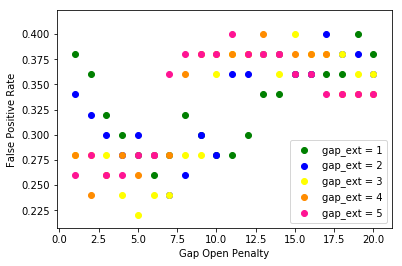

In [41]:
plt.scatter(df.loc[df["gap_ext"] == 1,:]['gap_open'],df.loc[df["gap_ext"] == 1,:]['FP'], c='g', label='gap_ext = 1')
plt.scatter(df.loc[df["gap_ext"] == 2,:]['gap_open'],df.loc[df["gap_ext"] == 2,:]['FP'], c='b', label='gap_ext = 2')
plt.scatter(df.loc[df["gap_ext"] == 3,:]['gap_open'],df.loc[df["gap_ext"] == 3,:]['FP'], c='yellow', label='gap_ext = 3')
plt.scatter(df.loc[df["gap_ext"] == 4,:]['gap_open'],df.loc[df["gap_ext"] == 4,:]['FP'], c='darkorange', label='gap_ext = 4')
plt.scatter(df.loc[df["gap_ext"] == 5,:]['gap_open'],df.loc[df["gap_ext"] == 5,:]['FP'], c='deeppink', label='gap_ext = 5')
plt.legend(loc='lower right')
plt.xlabel("Gap Open Penalty")
plt.ylabel("False Positive Rate")
plt.show()


In [23]:
df.to_csv('false_positives.csv')

Part 1.2

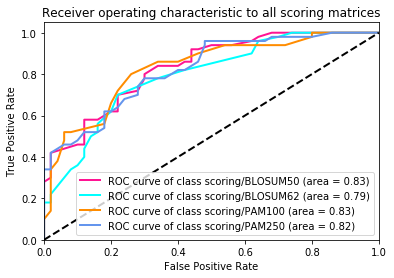

In [42]:
#ROC

#Load list of pos_pairs and neg_pairs
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
#Load list of scoring matrices
scoring_files = ["scoring/BLOSUM50","scoring/BLOSUM62","scoring/PAM100","scoring/PAM250"]
#Usng optimized gap opening penatlty (gap) and gap extension penalty (ext)
gap = opt_gap
ext = opt_ext
scoring_results = {}
fp_result_scoring = {}
#Calculate fpr (for TP of 0.7) and scoring predictions for each scoring matrix
for path in scoring_files:
    pos_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in pos_pairs]
    neg_scores = [smith_waterman(x[0], x[1], path, gap, ext) for x in neg_pairs]
    #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
    threshold = sorted(pos_scores)[14]
    false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
    true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
    fp_result_scoring[path] = [false_pos,true_pos]
    overall_scores = pos_scores + neg_scores
    scoring_results[path] = overall_scores

#Plot ROC curve
# Compute ROC curve and ROC area for each scoring matrix
y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr = dict()
tpr = dict()
roc_auc = dict()

for path in scoring_files:
    fpr[path], tpr[path], _ = roc_curve(y_true, scoring_results[path])
    roc_auc[path] = auc(fpr[path], tpr[path])


colors = ['deeppink','aqua', 'darkorange', 'cornflowerblue']
for path, color in zip(scoring_files, colors):
    plt.plot(fpr[path], tpr[path], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(path, roc_auc[path]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to all scoring matrices')
plt.legend(loc="lower right")
plt.show()

In [43]:
print(fp_result_scoring)

{'scoring/BLOSUM50': [0.22, 0.7], 'scoring/BLOSUM62': [0.22, 0.7], 'scoring/PAM100': [0.2, 0.66], 'scoring/PAM250': [0.28, 0.7]}


In [45]:
print(sorted(scoring_results['scoring/PAM100'][0:50])[13:18])
threshold = sorted(scoring_results['scoring/PAM100'][0:50])[13]
# #False positive rate for true positive rate of 0.72
np.sum(np.array(scoring_results['scoring/PAM100'][50:]) > threshold)/len(neg_scores)

[29.0, 30.0, 30.0, 30.0, 31.0]


0.22

Part 1.3

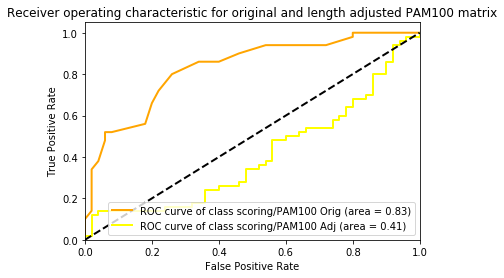

In [46]:
#ROC

#Load list of pos_pairs and neg_pairs
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
#Load list of scoring matrices
scoring_files = ["scoring/BLOSUM50","scoring/BLOSUM62","scoring/PAM100","scoring/PAM250"]
#Usng optimized gap opening penatlty (gap) and gap extension penalty (ext)
gap = opt_gap
ext = opt_ext
scoring_results_adj = {}
fp_result_scoring_adj = {}
#Calculate fpr (for TP of 0.7) and scoring predictions for each scoring matrix with the length adjusted score
for path in scoring_files:
    pos_scores = [smith_waterman_len_adj(x[0], x[1], path, gap, ext) for x in pos_pairs]
    neg_scores = [smith_waterman_len_adj(x[0], x[1], path, gap, ext) for x in neg_pairs]
    #Threshold for 0.7 True Positive Rate. (there are 50 Pos_pairs)
    threshold = sorted(pos_scores)[14]
    false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
    true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
    fp_result_scoring_adj[path] = [false_pos,true_pos]
    overall_scores = pos_scores + neg_scores
    scoring_results_adj[path] = overall_scores


# Compute ROC curve and ROC area for each scoring matrix with the length adjusted score
y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr_adj = dict()
tpr_adj = dict()
roc_auc_adj = dict()

for path in scoring_files:
    fpr_adj[path], tpr_adj[path], _ = roc_curve(y_true, scoring_results_adj[path])
    roc_auc_adj[path] = auc(fpr_adj[path], tpr_adj[path])

#Plot ROC for best matrix
colors = ['orange','yellow']
opt_path = 'scoring/PAM100'
plt.plot(fpr[opt_path], tpr[opt_path], color=colors[0], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(opt_path + " Orig", roc_auc[opt_path]))
plt.plot(fpr_adj[opt_path], tpr_adj[opt_path], color=colors[1], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(opt_path + " Adj", roc_auc_adj[opt_path]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for original and length adjusted PAM100 matrix')
plt.legend(loc="lower right")
plt.show()

In [47]:
print(roc_auc_adj)

{'scoring/BLOSUM50': 0.47319999999999995, 'scoring/BLOSUM62': 0.40340000000000004, 'scoring/PAM100': 0.40679999999999994, 'scoring/PAM250': 0.45339999999999997}


In [48]:
print(fp_result_scoring_adj)

{'scoring/BLOSUM50': [0.8, 0.7], 'scoring/BLOSUM62': [0.88, 0.7], 'scoring/PAM100': [0.86, 0.7], 'scoring/PAM250': [0.8, 0.7]}


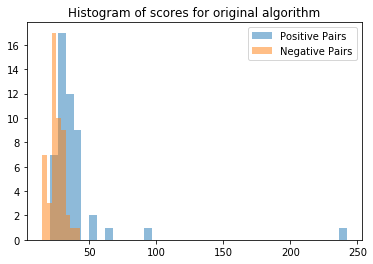

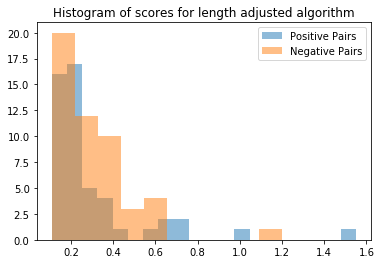

In [49]:
plt.hist(scoring_results['scoring/PAM100'][0:50], bins='auto', alpha = 0.5, label = "Positive Pairs")
plt.hist(scoring_results['scoring/PAM100'][50:], bins='auto', alpha = 0.5, label = "Negative Pairs")
plt.title("Histogram of scores for original algorithm")
plt.legend(loc='upper right')
plt.show()

plt.hist(scoring_results_adj['scoring/PAM100'][0:50], bins='auto', alpha = 0.5, label = "Positive Pairs")
plt.hist(scoring_results_adj['scoring/PAM100'][50:], bins='auto', alpha = 0.5, label = "Negative Pairs")
plt.title("Histogram of scores for length adjusted algorithm")
plt.legend(loc='upper right')
plt.show()

In [6]:
#Determine optimal local alginments for the optimum matrix from Part 1
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')

gap = opt_gap
ext = opt_ext
opt_matrix = 'scoring/PAM100'
opt_matrix_df = read_scoring_matrix(opt_matrix)
pos_seq = []
neg_seq = []
pos_scores = []
neg_scores =[]
for x in pos_pairs:
    opt_seq_a,opt_seq_b,score = smith_waterman_alignment(x[0], x[1], opt_matrix, gap, ext)
    if score_alignment(opt_seq_a, opt_seq_b, opt_matrix_df, gap, ext) != score:
        print (x[0], x[1])
        break
    pos_seq.append([opt_seq_a,opt_seq_b])
    pos_scores.append(score)
    print("Finished", x[0], x[1])
print("finished positives")
for x in neg_pairs:
    opt_seq_a,opt_seq_b,score = smith_waterman_alignment(x[0], x[1], opt_matrix, gap, ext)
    if score_alignment(opt_seq_a, opt_seq_b, opt_matrix_df, gap, ext) != score:
        print (x[0], x[1])
        break
    neg_seq.append([opt_seq_a,opt_seq_b])
    neg_scores.append(score)
    print("Finished", x[0], x[1])
        

Finished sequences/prot-0004.fa sequences/prot-0008.fa
Finished sequences/prot-0031.fa sequences/prot-0034.fa
Finished sequences/prot-0047.fa sequences/prot-0050.fa
Finished sequences/prot-0065.fa sequences/prot-0069.fa
Finished sequences/prot-0077.fa sequences/prot-0082.fa
Finished sequences/prot-0098.fa sequences/prot-0102.fa
Finished sequences/prot-0124.fa sequences/prot-0125.fa
Finished sequences/prot-0166.fa sequences/prot-0177.fa
Finished sequences/prot-0170.fa sequences/prot-0173.fa
Finished sequences/prot-0175.fa sequences/prot-0178.fa
Finished sequences/prot-0187.fa sequences/prot-0190.fa
Finished sequences/prot-0240.fa sequences/prot-0242.fa
Finished sequences/prot-0271.fa sequences/prot-0275.fa
Finished sequences/prot-0298.fa sequences/prot-0300.fa
Finished sequences/prot-0326.fa sequences/prot-0327.fa
Finished sequences/prot-0354.fa sequences/prot-0355.fa
Finished sequences/prot-0357.fa sequences/prot-0360.fa
Finished sequences/prot-0361.fa sequences/prot-0364.fa
Finished s

In [386]:
start = time.time()
path = 'scoring/PAM100'
#i = np.random.randint(0,high=50)
test_a, test_b, score= smith_waterman_alignment(pos_pairs[0][0], pos_pairs[0][1], path, 5, 3)
print(score)
score_mat = read_scoring_matrix(path)
print(score_alignment(test_a, test_b, score_mat, 5, 3))
print(time.time()-start)

25.0
25
1.0249450206756592


In [387]:
test_a

'AWGTAGPEF'

In [388]:
test_b

'AWHEIGREF'

In [71]:
#EMBOSS test case
#['sequences/prot-0031.fa', 'sequences/prot-0034.fa']
a = "VIEKAD---NAAQVK---DALTKMRAAALDAQKATP-----PKLEDKSPDS-PEM-KD---FR---HGFDILVGQIDDALKL---ANEGKVKEAQAA-AEQLKTTRNAYHQKYR"
b = "VV-KGQAPYDAAQIKANVEVLKTL--TAL------PWAAFGPGTE--GGDARPEIWSDAASFKQKQQAF-----Q-DNIVKLSAAADAGDLDKLRAAFGD-VGASCKACHDAYR"
score_mat = read_scoring_matrix(path)
score_alignment(a, b, score_mat, 4, 1)

74

In [158]:
#EMBOSS test case
#['sequences/prot-0102.fa', 'sequences/prot-0098.fa']
a = "IDRDAVLNMWQ-QGLGASHISKTMNIARSTVYK"
b = "IQR-GV-SPSQAQGLGSNLVT---EV-R--VYN"
score_mat = read_scoring_matrix(path)
score_alignment(a, b, score_mat, 4, 1)


38

Part 2.1 and 2.2

In [259]:
test = read_scoring_matrix('scoring/PAM100')
score_performance(pos_seq, neg_seq,test, 5,3)

2.08

In [260]:
test = read_scoring_matrix('scoring/BLOSUM50')
score_performance(pos_seq, neg_seq,test, 5,3)

1.48

In [348]:

def optimize_scoring_matrix(alignments_pos, alignments_neg, starting_matrix_path, gap_open, gap_ext, num_iterations):

    #Record start time
    start = time.time()
    #Load scoring matrix
    score_mat = read_scoring_matrix(starting_matrix_path)
    score_mat = score_mat.astype(np.float64)
    #Store column names 
    residues = score_mat.columns.tolist()
    #Intialize the iteration matrices and iteration score lists
    iteration_mat = [score_mat]*10
    
    #Initialize best iteration scores
    starting_score = score_performance(alignments_pos, alignments_neg, score_mat, gap_open, gap_ext)
    iteration_scores = [starting_score]*10
    print("Loaded initial matrix and scores")
    
    #Perform optimization with pool of matrices
    #Take top 10 scoring matrices
    #Mutate each one nine times to create pool of 100 matrices
    #Repeat
    iteration_counter = [0]
    iteration_score_counter = []
    iteration_score_counter.append([np.mean(iteration_scores),np.std(iteration_scores),np.max(iteration_scores)])
    
    for i in range(num_iterations):
        #Find top 10 matrices
        best_mat_scores = sorted(iteration_scores)[-10:]
        best_mat_indices = [iteration_scores.index(x) for x in best_mat_scores]

        #Make list of 100 matrices with each of the best ten repeated ten times
        new_matrices = []
        new_scores = []
        for j in range(10):
            new_matrices = new_matrices + [iteration_mat[best_mat_indices[j]]]*10
            new_scores = new_scores + [iteration_scores[best_mat_indices[j]]]*10

        iteration_mat = new_matrices
        iteration_scores = new_scores

        #Mutate the 9 copies but keep one of each of the originals
        for k in list(set(range(100))-set([0,10,20,30,40,50,60,70,80,90])):
            rand_adj = pd.DataFrame(np.zeros((24,24)), columns = residues, index = residues)
            for b in range(24):
                for c in range(b,24):
                    rand_adj.iloc[b,c] += uniform(-1,1)
                    rand_adj.iloc[c,b] = rand_adj.iloc[b,c]
            iteration_mat[k] = iteration_mat[k] + rand_adj
            iteration_scores[k] = score_performance(alignments_pos, alignments_neg, iteration_mat[k], gap_open, gap_ext)
        iteration_counter.append(i+1)
        iteration_score_counter.append([np.mean(iteration_scores),np.std(iteration_scores), np.max(iteration_scores)])
        print("Finished iteration", i+1)
    new_matrix_score = max(iteration_scores)
    new_matrix = iteration_mat[iteration_scores.index(max(iteration_scores))]
    end = time.time()
    total_time = (end-start)/60
    return iteration_mat, iteration_scores, new_matrix, new_matrix_score, starting_score, iteration_counter, iteration_score_counter, total_time    
 
    

In [360]:
start = time.time()
output = optimize_scoring_matrix(pos_seq, neg_seq, 'scoring/PAM100', opt_gap, opt_ext, 100)
print(time.time()-start)

Loaded initial matrix and scores
Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
Finished iteration 39
Finished iteration 40
Finished iteration 41
Finished iteration 42
Finished iteration 43
Finished iteration 44
Finished

In [371]:
output[6]

[[2.0799999999999996, 4.440892098500626e-16, 2.08],
 [2.1261999999999994, 0.12543348835139678, 2.5],
 [2.2288, 0.141203965949969, 2.56],
 [2.3536, 0.13016543319944815, 2.66],
 [2.3482000000000003, 0.18878760552536283, 2.7600000000000002],
 [2.4656000000000002, 0.1650473871347256, 2.9399999999999995],
 [2.5063999999999997, 0.17997510939015987, 2.9399999999999995],
 [2.5640000000000005, 0.1643167672515498, 2.9399999999999995],
 [2.609, 0.17151967817133987, 3.06],
 [2.6438000000000006, 0.17428011934813442, 3.1199999999999997],
 [2.6488, 0.18190810867028437, 3.1199999999999997],
 [2.6768, 0.1829474241414729, 3.1199999999999997],
 [2.7042, 0.18424537986066292, 3.1199999999999997],
 [2.7576000000000005, 0.1774098080715944, 3.1199999999999997],
 [2.7278000000000002, 0.19214359213879595, 3.1199999999999997],
 [2.7362, 0.18259671409967917, 3.1199999999999997],
 [2.7656, 0.1807557467966094, 3.1199999999999997],
 [2.7432000000000003, 0.19595346386323456, 3.1399999999999997],
 [2.7638, 0.199993899

In [377]:
print(score_performance(pos_seq,neg_seq,output[2],5,3) == output[3])
print(output[3])

True
3.9


In [376]:
def score_performance(pos_sequences,neq_sequences,scoring_matrix, gap,ext):
    ##Caluclate the performance for the current scoring matrix
    pos_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in pos_sequences]
    neg_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in neq_sequences]
    #Find thresholds for 0, 0.1, 0.2, and 0.3 false positive rate. (there are 50 Pos_pairs)
    thresholds = []
    thresholds.append(sorted(neg_scores)[-1])
    thresholds.append(sorted(neg_scores)[-6])
    thresholds.append(sorted(neg_scores)[-11])
    thresholds.append(sorted(neg_scores)[-16])
    #Calculate true_pos rate at each score
    false_pos = []
    true_pos = []
    for value in thresholds:
        false_pos.append(np.sum(np.array(neg_scores) > value)/len(neg_scores))
        true_pos.append(np.sum(np.array(pos_scores) > value)/len(pos_scores))
    overall_score = np.sum(true_pos)
    return overall_score


In [97]:
df_pos = pd.DataFrame({'pos':pos_seq})
df_pos.to_csv('tests/pos_seq.csv')

In [98]:
df_neg = pd.DataFrame({'neg':neg_seq})
df_neg.to_csv('tests/neg_seq.csv')

In [365]:
def write_optimal_matrix(filename, k, path, opt_matrix, opt_matrix_score, original_score,time):
    """
    Write the optimal scoring matrix out to a file.

    Input: a filename and the output from optimize_scoring_matrix
    Output: none
    """

    out = open(filename, 'w')
    out.write("# Optimal Matrix after %d iterations on %s scoring matrix\n" % (k, path))
    out.write("# Time (min) %d \n" % time)
    out.write("# Original matrix score %d \n" % original_score)
    out.write("# New matrix score %d \n" % opt_matrix_score)
    out.close()
    opt_matrix.to_csv(filename, index=None, sep=' ', mode='a')

In [366]:
write_optimal_matrix('/Users/elizabeth/Desktop/BMI203_HW3/data/optimization/opt_PAM100',100,'scoring/PAM100',output[2],output[3],output[4],output[-1])



In [380]:
def score_performance_all(pos_sequences,neq_sequences,scoring_matrix, gap,ext):
    ##Caluclate the performance for the current scoring matrix
    pos_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in pos_sequences]
    neg_scores = [score_alignment(x[0], x[1], scoring_matrix, gap, ext) for x in neq_sequences]
    #Find thresholds for 0, 0.1, 0.2, and 0.3 false positive rate. (there are 50 Pos_pairs)
    thresholds = []
    thresholds.append(sorted(neg_scores)[-1])
    thresholds.append(sorted(neg_scores)[-6])
    thresholds.append(sorted(neg_scores)[-11])
    thresholds.append(sorted(neg_scores)[-16])
    #Calculate true_pos rate at each score
    false_pos = []
    true_pos = []
    for value in thresholds:
        false_pos.append(np.sum(np.array(neg_scores) > value)/len(neg_scores))
        true_pos.append(np.sum(np.array(pos_scores) > value)/len(pos_scores))
    overall_score = np.sum(true_pos)
    return overall_score,false_pos,true_pos

In [381]:
test = read_scoring_matrix('optimization/opt_PAM100')
print(score_performance_all(pos_seq,neg_seq,test,5,3))

(3.9, [0.0, 0.1, 0.2, 0.3], [0.96, 0.98, 0.98, 0.98])


Part 2.3

In [367]:
#ROC
#Plot ROC for initial alignments for original matrix and optimized matrix
scoring_results = {}
fp_result_scoring = {}
#Original
path = 'scoring/PAM100'
scoring_matrix = read_scoring_matrix(path)
pos_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in pos_seq]
neg_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in neg_seq]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path] = overall_scores

#Optimized
path = 'optimization/opt_PAM100'
scoring_matrix = read_scoring_matrix(path)
pos_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in pos_seq]
neg_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in neg_seq]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path] = overall_scores

#Optimized New alignments
path = 'optimization/opt_PAM100'
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
pos_scores = [smith_waterman(x[0], x[1], path, 5, 3) for x in pos_pairs]
neg_scores = [smith_waterman(x[0], x[1], path, 5, 3) for x in neg_pairs]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path + 'calc'] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path + 'calc'] = overall_scores

y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr = dict()
tpr = dict()
roc_auc = dict()

for path in list(scoring_results.keys()):
    fpr[path], tpr[path], _ = roc_curve(y_true, scoring_results[path])
    roc_auc[path] = auc(fpr[path], tpr[path])

colors = ['deeppink','aqua', 'darkorange']
i = 0
for path in list(scoring_results_adj.keys()): 
    plt.plot(fpr[path], tpr[path], color=colors[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(path, roc_auc[path]))
    i = i+1

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for original,optimized, and re-aligned sequences with optimized matrix scoring for PAM100 matrix')
plt.legend(loc="lower right")
plt.show()

 

NameError: name 'fpr' is not defined

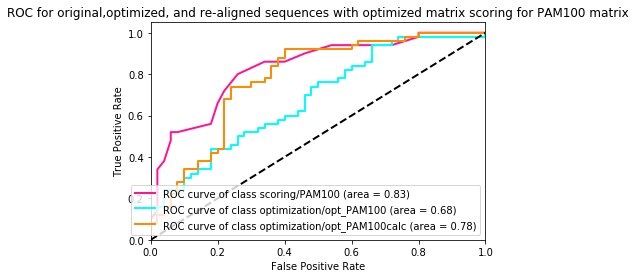

In [369]:
y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr = dict()
tpr = dict()
roc_auc = dict()

for path in list(scoring_results.keys()):
    fpr[path], tpr[path], _ = roc_curve(y_true, scoring_results[path])
    roc_auc[path] = auc(fpr[path], tpr[path])

colors = ['deeppink','aqua', 'darkorange']
i = 0
for path in list(scoring_results.keys()): 
    plt.plot(fpr[path], tpr[path], color=colors[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(path, roc_auc[path]))
    i = i+1

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for original,optimized, and re-aligned sequences with optimized matrix scoring for PAM100 matrix')
plt.legend(loc="lower right")
plt.show()

In [370]:
print(fp_result_scoring)

{'scoring/PAM100': [0.2, 0.66], 'optimization/opt_PAM100': [0.48, 0.7], 'optimization/opt_PAM100calc': [0.24, 0.7]}


In [ ]:
#Plot Optimization Performance
mean_values = [output[6][i][0] for i in range(101)]
std_values = [output[6][i][1] for i in range(101)]
max_values = [output[6][i][2] for i in range(101)]
iteration_values = list(range(101))
plt.errorbar(x=iteration_values, y=mean_values, yerr = std_values, marker='^', ecolor = "black")

plt.xlabel('Iteration Number') 
plt.ylabel('Mean of the scores of matrices for optimizing PAM100')
plt.show()



Part 2.3

In [ ]:
start = time.time()
output_MATIO = optimize_scoring_matrix(pos_seq, neg_seq, 'optimization/MATIO', opt_gap, opt_ext, 100)
print(time.time()-start)



In [ ]:
write_optimal_matrix('/Users/elizabeth/Desktop/BMI203_HW3/data/optimization/opt_MATIO',100,'optimization/MATIO',output_MATIO[2],output_MATIO[3],output_MATIO[4],output_MATIO[-1])



In [ ]:
#ROC
#Plot ROC for initial alignments for original matrix and optimized matrix
scoring_results = {}
fp_result_scoring = {}
#Original
path = 'optimization/MATIO'
scoring_matrix = read_scoring_matrix(path)
pos_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in pos_seq]
neg_scores = [score_alignment(x[0], x[1], scoring_matrix, 5, 3) for x in neg_seq]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path] = overall_scores

#Optimized
path = 'optimization/MATIO'
scoring_matrix = read_scoring_matrix(path)
pos_scores = [score_alignment(x[0], x[0], scoring_matrix, 5, 3) for x in pos_seq]
neg_scores = [score_alignment(x[0], x[0], scoring_matrix, 5, 3) for x in neg_seq]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path] = overall_scores

#Optimized New alignments
path = 'optimization/MATIO'
pos_pairs = read_pairs('pairs/Pospairs.txt')
neg_pairs = read_pairs('pairs/Negpairs.txt')
pos_scores = [smith_waterman(x[0], x[1], path, 5, 3) for x in pos_pairs]
neg_scores = [smith_waterman(x[0], x[1], path, 5, 3) for x in neg_pairs]
threshold = sorted(pos_scores)[14]
false_pos = np.sum(np.array(neg_scores) > threshold)/len(neg_scores)
true_pos = np.sum(np.array(pos_scores) > threshold)/len(pos_scores)
fp_result_scoring[path + 'calc'] = [false_pos,true_pos]
overall_scores = pos_scores + neg_scores
scoring_results[path + 'calc'] = overall_scores

y_true = [1]*len(pos_pairs) + [0]*len(neg_pairs)
fpr_adj = dict()
tpr_adj = dict()
roc_auc_adj = dict()

for path in list(scoring_results.keys()):
    fpr[path], tpr[path], _ = roc_curve(y_true, scoring_results[path])
    roc_auc[path] = auc(fpr[path], tpr[path])

colors = ['deeppink','aqua', 'darkorange']
i = 0
for path in list(scoring_results_adj.keys()): 
    plt.plot(fpr[path], tpr[path], color=colors[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(path, roc_auc[path]))
    i = i+1

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for original,optimized, and re-aligned sequences with optimized matrix scoring for MATIO matrix')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(fp_result_scoring)

In [ ]:
#Plot Optimization Performance
mean_values = [output_MATIO[6][i][0] for i in range(101)]
std_values = [output_MATIO[6][i][1] for i in range(101)]
max_values = [output_MATIO[6][i][2] for i in range(101)]
iteration_values = list(range(101))
plt.errorbar(x=iteration_values, y=mean_values, yerr = std_values, marker='^', ecolor = "black")

plt.xlabel('Iteration Number') 
plt.ylabel('Mean of the scores of matrices for optimizing MATIO')
plt.show()